In [1]:
import pandas as pd
import numpy as np

import yaml

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from eif import iForest

RAND=42

In [2]:
def get_bins_target(df: pd.DataFrame, target_name: str) -> None:
    # нормирование на размер датасета
    norm_target = (df[target_name].value_counts(
        normalize=True).mul(100).rename('percent').reset_index())

    plt.figure(figsize=(15, 7))
    ax = sns.barplot(x='index', y='percent', data=norm_target)

    # Вывод значений над графиками - annotate()
    # В цикле смотрим каждый столбец графика и на нем отмечаем значения
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)

    plt.title(target_name, fontsize=20)
    plt.xlabel(target_name, fontsize=14)
    plt.ylabel('Проценты', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [3]:
def barplot_group(col_main: str, col_group: str, title: str = None) -> None:
    """
    Построение barplot с нормированными данными с выводом значений на графике
    """

    plt.figure(figsize=(15, 6))

    data = (df.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="percentage",
                     hue=col_group, data=data, palette='viridis')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),  # координата xy
                    ha='center',  # центрирование
                    va='center',
                    xytext=(0, 7),
                    textcoords='offset points',  # точка смещения относительно координаты
                    fontsize=12)

    plt.title(title, fontsize=16)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)
    plt.show()

In [4]:
pd.set_option('display.max_rows', 1000)

# Описание задачи

https://www.kaggle.com/competitions/alfa-bank-pd-credit-history

**Кредитный скоринг** – важнейшая банковская задача. Стандартным подходом к ее решению является построение классических моделей машинного обучения, таких как логистическая регрессия и градиентный бустинг, на табличных данных, в том числе используя агрегации от каких-нибудь последовательных данных, например, транзакционных историй клиентов. Альтернативный подход заключается в использовании последовательных данных “как есть”, подавая их на вход рекуррентной нейронной сети.

На предоставленных данных необходимо решить задачу кредитного скоринга клиентов Альфа-Банка, используя только данные кредитных историй.

**Данные** устроен таким образом, что кредиты для тренировочной выборки взяты за период в М месяцев, а кредиты для тестовой выборки взяты за последующие K месяцев.

Каждая запись кредитной истории содержит самую разнообразную информацию о прошлом кредите клиента, например, сумму, отношение клиента к кредиту, дату открытия и закрытия, информацию о просрочках по платежам и др. Все публикуемые данные тщательно анонимизированы.

**Целевая переменная** – бинарная величина, принимающая значения 0 и 1, где 1 соответствует дефолту клиента по кредиту.

**Описание признаков** содержится в файле ../raw/description.xlsx

# Preprocessing

In [5]:
x_path = "../data/raw/train_data/train_data_0.pq"
df_X = pd.read_parquet(x_path)
df_X[:5]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [6]:
df_X.shape

(1974724, 61)

In [7]:
df_X.nunique()

id                               250000
rn                                   51
pre_since_opened                     20
pre_since_confirmed                  18
pre_pterm                            18
pre_fterm                            17
pre_till_pclose                      17
pre_till_fclose                      16
pre_loans_credit_limit               20
pre_loans_next_pay_summ               7
pre_loans_outstanding                 5
pre_loans_total_overdue               1
pre_loans_max_overdue_sum             3
pre_loans_credit_cost_rate           14
pre_loans5                            8
pre_loans530                         15
pre_loans3060                         5
pre_loans6090                         3
pre_loans90                           4
is_zero_loans5                        2
is_zero_loans530                      2
is_zero_loans3060                     2
is_zero_loans6090                     2
is_zero_loans90                       2
pre_util                             20


In [8]:
#Признак pre_loans_total_overdue неинформативный, так как содержит одно уникальное значение
df_X = df_X.drop(columns=["pre_loans_total_overdue"])

In [9]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Data columns (total 60 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_max_overdue_sum      int64
 12  pre_loans_credit_cost_rate     int64
 13  pre_loans5                     int64
 14  pre_loans530                   int64
 15  pre_loans3060                  int64
 16  pre_loans6090                  int64
 17  pre_loans90                    int64
 18  is_zero_loans5                 int64
 19  

In [10]:
df_X = df_X.set_index(["id"])

In [11]:
df_X[:5]

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
id,,,,,,,,,,,,,,,,,,,,,
0,1,18,9,2,3,16,10,11,3,3,...,3,3,3,4,1,3,4,1,0,0
0,2,18,9,14,14,12,12,0,3,3,...,0,0,0,4,1,3,4,1,0,0
0,3,18,9,4,8,1,11,11,0,5,...,0,0,0,4,1,2,3,1,1,1
0,4,4,1,9,12,16,7,12,2,3,...,3,3,3,4,1,3,1,1,0,0
0,5,5,12,15,2,11,12,10,2,3,...,3,3,3,4,1,3,4,1,0,0


In [12]:
df_X.describe().iloc[1:, :]

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
mean,6.537471,9.271325,8.330264,8.299071,8.309444,6.991781,8.337011,9.740888,2.399848,3.012951,...,2.313242,2.343014,2.376717,3.576724,1.027562,2.694898,3.353936,1.002386,0.172138,0.223934
std,5.121167,5.773757,4.593511,5.245598,4.464844,5.184165,4.233992,5.799625,1.376391,0.683844,...,1.247674,1.228473,1.205555,1.035586,0.276702,0.489136,1.057304,0.059093,0.377501,0.416878
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,5.000000,4.000000,6.000000,1.000000,5.000000,5.000000,2.000000,3.000000,...,3.000000,3.000000,3.000000,4.000000,1.000000,2.000000,3.000000,1.000000,0.000000,0.000000
50%,5.000000,9.000000,9.000000,8.000000,8.000000,6.000000,10.000000,10.000000,2.000000,3.000000,...,3.000000,3.000000,3.000000,4.000000,1.000000,3.000000,4.000000,1.000000,0.000000,0.000000
75%,9.000000,14.000000,11.000000,13.000000,12.000000,12.000000,11.000000,15.000000,2.000000,3.000000,...,3.000000,3.000000,3.000000,4.000000,1.000000,3.000000,4.000000,1.000000,0.000000,0.000000
max,51.000000,19.000000,17.000000,17.000000,16.000000,16.000000,15.000000,19.000000,6.000000,5.000000,...,3.000000,3.000000,3.000000,4.000000,6.000000,6.000000,5.000000,3.000000,1.000000,1.000000


In [13]:
df_X.isna().sum()

rn                               0
pre_since_opened                 0
pre_since_confirmed              0
pre_pterm                        0
pre_fterm                        0
pre_till_pclose                  0
pre_till_fclose                  0
pre_loans_credit_limit           0
pre_loans_next_pay_summ          0
pre_loans_outstanding            0
pre_loans_max_overdue_sum        0
pre_loans_credit_cost_rate       0
pre_loans5                       0
pre_loans530                     0
pre_loans3060                    0
pre_loans6090                    0
pre_loans90                      0
is_zero_loans5                   0
is_zero_loans530                 0
is_zero_loans3060                0
is_zero_loans6090                0
is_zero_loans90                  0
pre_util                         0
pre_over2limit                   0
pre_maxover2limit                0
is_zero_util                     0
is_zero_over2limit               0
is_zero_maxover2limit            0
enc_paym_0          

In [14]:
y_path = "../data/raw/train_target.csv"
Y = pd.read_csv(y_path, nrows=250000)
Y[:5]

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [15]:
Y = Y.set_index('id')

In [16]:
Y.isna().sum()

flag    0
dtype: int64

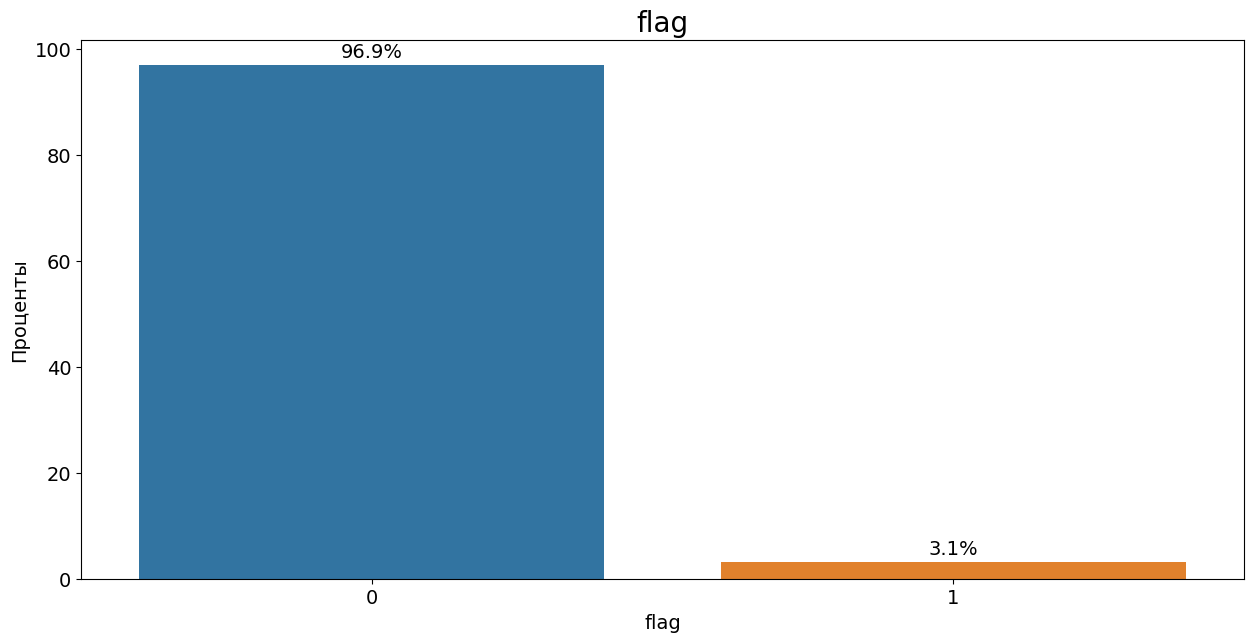

In [17]:
# из графика видно, что есть дисбаланс целевой переменной
get_bins_target(Y, "flag")

In [18]:
# сформируем датасет с последним кредитом клиента
df = df_X.groupby(level=0).last().join(Y) 

In [19]:
df[:5]

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
id,,,,,,,,,,,,,,,,,,,,,
0,10,7,9,2,10,8,8,16,4,2,...,3,3,4,1,2,4,1,0,0,0
1,14,12,6,1,8,14,11,11,2,3,...,3,3,4,1,2,3,1,0,1,0
2,3,12,9,4,8,1,11,1,1,4,...,3,3,4,1,2,3,1,1,1,0
3,15,12,9,2,10,8,8,17,1,2,...,3,3,4,1,2,4,1,0,0,0
4,1,12,9,4,8,1,11,12,1,3,...,3,3,4,1,2,3,1,1,1,0


In [20]:
df.shape

(250000, 60)

#### Выводы

- В данных нет пропусков  
- Все первичные признаки закодированы и приведены к типу int  
- Датасет имеет выраженный дисбаланс классов  
- Среднее кол-во записей в кредитной истории клиента - 6-7  
- Признак pre_loans_total_overdue не является информативным, так как имеет 1 уникальное значение (удален)
- Все признаки отмасштабированы

## Feature engineering

In [21]:
def transform_dataframe(df: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Добавление к датафрейму n последних операций из истории клиента путем создания новых столбцов
    :df: датасет со всеми операциями
    :n: номер операции начиная с последней
    """
    df_res = df.groupby(level=0).last().join(Y) 
    
    for i in range(2, n+1):
        df_res = df_res.join(df.iloc[:,1:].groupby(level=0).nth(-i), rsuffix=f'_{i}', how='left')
    
    return df_res.fillna(0)

In [22]:
# Трансформируем датасет
df = transform_dataframe(df_X, 4)

In [23]:
df.shape

(250000, 234)

In [29]:
df[:5]

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_21_4,enc_paym_22_4,enc_paym_23_4,enc_paym_24_4,enc_loans_account_holder_type_4,enc_loans_credit_status_4,enc_loans_credit_type_4,enc_loans_account_cur_4,pclose_flag_4,fclose_flag_4
id,,,,,,,,,,,,,,,,,,,,,
0,10,7,9,2,10,8,8,16,4,2,...,3.0,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0
1,14,12,6,1,8,14,11,11,2,3,...,3.0,3.0,3.0,4.0,1.0,2.0,4.0,1.0,0.0,0.0
2,3,12,9,4,8,1,11,1,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15,12,9,2,10,8,8,17,1,2,...,3.0,3.0,3.0,4.0,1.0,2.0,1.0,1.0,0.0,1.0
4,1,12,9,4,8,1,11,12,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cleaning data

In [25]:
# Для поиска и удаления аномальных значений будет использован алгоритм Isolation Forest
# Из-за дисбаланса классов на вход алгоритму подаем только операции, по которым нет дефолта
column_eif = iForest(df[df["flag"]==0].values, ntrees=300, 
                     sample_size=128, ExtensionLevel=1)

In [26]:
S1 = column_eif.compute_paths(X_in = df[df["flag"]==0].values)

indexes_eif = np.argsort(S1)[-int(len(S1) * 0.05):]
df = df.drop(index=indexes_eif)

In [27]:
df.shape

(237887, 234)

In [28]:
df.to_parquet("../data/processed/train_data_proc.pq", index='id')